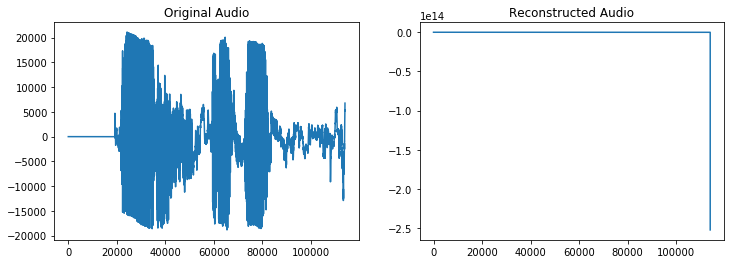

Torch points of original and reconstructed audio are equal: False
PESQ Score (NB): 1.069064974784851
PESQ Score (WB): 1.1596176624298096
STOI Score: 0.9467867612838745


In [7]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from torchmetrics.audio import ShortTimeObjectiveIntelligibility
import torchaudio

class AudioProcessor:
    def load_and_resample_audio(self, file_path, target_sample_rate):
        """
        Load audio from a WAV file and resample it to the target sample rate.

        Parameters:
        - file_path (str): Path to the WAV file.
        - target_sample_rate (int): Target sample rate for resampling.

        Returns:
        - resampled_audio (numpy.ndarray): Resampled audio waveform.
        - target_sample_rate (int): Target sample rate.
        """
        with wave.open(file_path, 'rb') as wave_file:
            original_sample_rate = wave_file.getframerate()
            audio_data = np.frombuffer(wave_file.readframes(-1), dtype=np.int16)

        # Calculate the number of frames needed for the target sample rate
        num_frames = int(len(audio_data) * target_sample_rate / original_sample_rate)

        # Use linear interpolation for resampling
        resampled_audio = np.interp(
            np.linspace(0, len(audio_data) - 1, num_frames),
            np.arange(len(audio_data)),
            audio_data
        )

        return resampled_audio, target_sample_rate

class SpectrogramProcessor:
    def compute_stft(self, audio_waveform, sample_rate, n_fft=400, hop_length=160, win_length=400):
        """
        Compute Short-Time Fourier Transform (STFT) of an audio waveform.

        Parameters:
        - audio_waveform (numpy.ndarray): Input audio waveform.
        - sample_rate (int): Sample rate of the audio waveform.
        - n_fft (int): Number of FFT points.
        - hop_length (int): Hop length for STFT.
        - win_length (int): Window length for STFT.

        Returns:
        - magnitude (numpy.ndarray): Magnitude spectrogram.
        - phase (numpy.ndarray): Phase spectrogram.
        """
        num_frames = (len(audio_waveform) - win_length) // hop_length + 1
        magnitude = np.zeros((num_frames, n_fft // 2 + 1))
        phase = np.zeros((num_frames, n_fft // 2 + 1), dtype=np.complex128)

        for i in range(num_frames):
            start = i * hop_length
            end = start + win_length
            frame = audio_waveform[start:end] * np.hanning(win_length)

            spectrum = np.fft.fft(frame, n_fft)
            magnitude[i] = np.abs(spectrum[:n_fft // 2 + 1])
            phase[i] = np.angle(spectrum[:n_fft // 2 + 1])

        return magnitude, phase

    def compute_istft(self, magnitude, phase, sample_rate, hop_length=160, win_length=400):
        """
        Compute Inverse Short-Time Fourier Transform (ISTFT) from magnitude and phase spectrograms.

        Parameters:
        - magnitude (numpy.ndarray): Magnitude spectrogram.
        - phase (numpy.ndarray): Phase spectrogram.
        - sample_rate (int): Sample rate of the audio waveform.
        - hop_length (int): Hop length for ISTFT.
        - win_length (int): Window length for ISTFT.

        Returns:
        - reconstructed_waveform (numpy.ndarray): Reconstructed audio waveform.
        """
        num_frames, num_bins = magnitude.shape
        n_fft = (num_bins - 1) * 2
        reconstructed_waveform = np.zeros((num_frames - 1) * hop_length + win_length)

        for i in range(num_frames):
            start = i * hop_length
            end = start + win_length

            # Reconstruct complex spectrum
            spectrum = np.zeros(n_fft, dtype=np.complex128)
            spectrum[:num_bins] = magnitude[i] * np.exp(1j * phase[i])

            # Perform ISTFT
            frame = np.fft.ifft(spectrum, n_fft).real
            reconstructed_waveform[start:end] += frame

        # Normalize by the sum of squared windows, avoiding division by zero
        window = np.hanning(win_length)
        norm_factor = np.zeros_like(reconstructed_waveform) + 1e-12

        for i in range(num_frames):
            start = i * hop_length
            end = start + win_length
            norm_factor[start:end] += window ** 2

        reconstructed_waveform /= norm_factor
        return reconstructed_waveform


# Sample WAV file path
file_path = 'arun.wav'
target_sample_rate = 48000

# Create instances of the classes
audio_processor = AudioProcessor()
spectrogram_processor = SpectrogramProcessor()

# Load and resample audio
resampled_waveform, original_sample_rate = audio_processor.load_and_resample_audio(file_path, target_sample_rate)

# Compute STFT
magnitude, phase = spectrogram_processor.compute_stft(resampled_waveform, original_sample_rate)

# Compute ISTFT
reconstructed_waveform = spectrogram_processor.compute_istft(magnitude, phase, original_sample_rate)

# Plot original and result waveforms
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(resampled_waveform)
plt.title("Original Audio")

plt.subplot(1, 2, 2)
plt.plot(reconstructed_waveform)
plt.title("Reconstructed Audio")

plt.show()

# Convert original and reconstructed waveforms to PyTorch tensors
original_waveform_tensor = torch.tensor(resampled_waveform, dtype=torch.float32)
reconstructed_waveform_tensor = torch.tensor(reconstructed_waveform, dtype=torch.float32)

# Compare PyTorch points
torch_points_equal = torch.equal(original_waveform_tensor, reconstructed_waveform_tensor)
print(f"Torch points of original and reconstructed audio are equal: {torch_points_equal}")

# Resample waveforms for PESQ
resampled_original_waveform = torchaudio.transforms.Resample(original_sample_rate, 16000)(original_waveform_tensor)
resampled_reconstructed_waveform = torchaudio.transforms.Resample(original_sample_rate, 16000)(reconstructed_waveform_tensor)

# Compute PESQ and STOI using torchmetrics
pesq_nb = perceptual_evaluation_speech_quality(resampled_reconstructed_waveform, resampled_original_waveform, 16000, 'nb')
pesq_wb = perceptual_evaluation_speech_quality(resampled_reconstructed_waveform, resampled_original_waveform, 16000, 'wb')

stoi = ShortTimeObjectiveIntelligibility(16000, False)
stoi_score = stoi(resampled_reconstructed_waveform, resampled_original_waveform)

# Print the results
print(f"PESQ Score (NB): {pesq_nb.item()}")
print(f"PESQ Score (WB): {pesq_wb.item()}")
print(f"STOI Score: {stoi_score.item()}")
